# 6 - Exploration of Historical NBA Team Offenses
Now that we've kinda realized that basketball is more than just a few numbers, let's continue to use numbers to understand basketball. Bahah. Okay, I mean my realization now is along the lines of you can't just be pitting one number against another. I can't look at ORB and expect it to explain something about ORtg or W/L%. Rather, we have to look at numbers collectively to understand why they are the way they are. A lower ORB team, as we figured with the warriors, might be doing other things to help them win. Or, rather, their style of play just doesn't lend to much offensive rebounds!

Anyways, these are all just guesses for now but, again, numbers must be looked at as an ensemble.
![](http://i.makeagif.com/media/9-28-2015/H8PLvc.gif)

## The Good, The Bad, and The Ugly
I think I've essentially took a step back. I thought I knew which numbers to look at, I don't even anymore. I'm stepping back to a 10000 ft. view and I basically think I don't even know what a good team looks like. What do they do well? What don't they do well? What do they need to do well? Which things that they do well dictate the style of their play?

I know that, for winning, ORtg > DRtg. But even in terms of offense, how are good teams good? The scoring? The rebounding? The accuracy of shooting? I can already see 2 posts into the future where I'm just as dumbfounded as I am now because I don't have all the data / the right data, but I will have to start somewhere.

Let's try to get some sense of what kind of patterns good teams exhibit, okay teams exhibit, and bad teams exhibit:

In [288]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [289]:
%%R
# Load libraries & initial config
library(ggplot2)
library(gridExtra)
library(scales)

In [290]:
# Load libraries & initial config
%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO

In [291]:
# Retrieve team stats from S3
teamAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/teamAggDfToAnalyze.csv', index_col = 0)
print teamAggDfToAnalyze.dtypes

baseStats_Season                object
perGameStats_Tm                 object
baseStats_W                      int64
baseStats_L                      int64
baseStats_WLPerc               float64
baseStats_SRS                  float64
baseStats_Pace                 float64
baseStats_Rel_Pace             float64
baseStats_ORtg                 float64
baseStats_Rel_ORtg             float64
baseStats_DRtg                 float64
baseStats_Rel_DRtg             float64
perGameStats_Age               float64
perGameStats_MP                float64
perGameStats_FG                float64
perGameStats_FGA               float64
perGameStats_FGPerc            float64
perGameStats_2P                float64
perGameStats_2PA               float64
perGameStats_2PPerc            float64
perGameStats_3P                float64
perGameStats_3PA               float64
perGameStats_3PPerc            float64
perGameStats_FT                float64
perGameStats_FTA               float64
perGameStats_FTPerc      

Let's run the function we wrote last post to adjust the main stats for pace again.

In [292]:
# This function adjusts the input stats for pace and outputs per 100 possession metrics
def paceConversion(df, listOfFields):
    for field in listOfFields:
        df['{}_per_100_poss'.format(field)] = (100/df['baseStats_Pace'])*(48/(df['perGameStats_MP']/5))*df[field]
        
    return df

# Select a subset of columns to manage size of dataframe
teamAggDfToAnalyzeSelectedColumns = teamAggDfToAnalyze[[
    'season_start_year',
    'perGameStats_Tm',
    'baseStats_W',
    'baseStats_WLPerc',
    'perGameStats_MP',
    'baseStats_Pace',
    'baseStats_Rel_Pace',
    'baseStats_ORtg',
    'baseStats_Rel_ORtg',
    'baseStats_DRtg',
    'baseStats_Rel_DRtg',
    'perGameStats_PTS',
    'perGameStats_2PA',
    'perGameStats_2PPerc',
    'perGameStats_3PA',
    'perGameStats_3PPerc',
    'perGameStats_FTA',
    'perGameStats_FTPerc',
    'perGameStats_ORB',
    'perGameStats_DRB',
    'perGameStats_AST',
    'perGameStats_STL',
    'perGameStats_BLK',
    'perGameStats_TOV'
]]

# Pace adjust the following metrics
teamAggDfToAnalyzePaceAdjusted = paceConversion(
    teamAggDfToAnalyzeSelectedColumns,
    [
        'perGameStats_PTS',
        'perGameStats_2PA',
        'perGameStats_3PA',
        'perGameStats_FTA',
        'perGameStats_ORB',
        'perGameStats_DRB',
        'perGameStats_AST',
        'perGameStats_STL',
        'perGameStats_BLK',
        'perGameStats_TOV'
    ]
)

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [293]:
# Check number of teams in history
print 'There have been {} teams in NBA history'.format(teamAggDfToAnalyzePaceAdjusted.shape[0])

There have been 1453 teams in NBA history


Okay, so we have 1453 teams to work with. Let's just take the top 10 teams, middle 10 teams, and worst 10 teams in NBA offence history and see if we can find any patterns.

First, I just want to refresh my memory and see if ORtg and W/L% correlate at all:

<IPython.core.display.Javascript object>


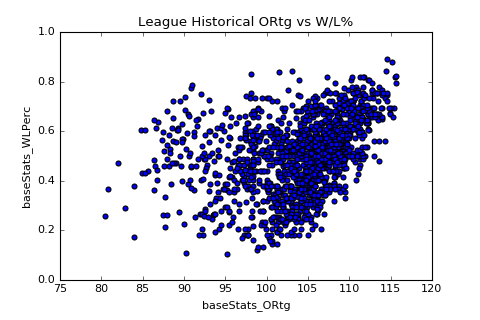

In [294]:
# Just trying out some quick pandas matplotlib plotting methods... pretty simple one liner!
teamAggDfToAnalyzePaceAdjusted.plot(kind = 'scatter', x = 'baseStats_ORtg', y = 'baseStats_WLPerc', title = 'League Historical ORtg vs W/L%')

The answer, again, kinda! Anyways, that was just so I can keep in the back of my mind if I can expect the top few ORtg teams to be winning teams and the bottom few ORtg teams to be losing teams. The answer is roughly yes.

In [295]:
# Define a dictionary in which we'll hold the top, middle, and bottom teams
teamAggDfToAnalyzeTiers = {}

# Define the number of teams to take in each "tier"
topN = 10

# First sort by ORtg and reset index
teamAggDfToAnalyzePaceAdjusted.sort_values('baseStats_ORtg', ascending = False, inplace = True)
teamAggDfToAnalyzePaceAdjusted.reset_index(inplace = True)
teamAggDfToAnalyzePaceAdjusted.drop('index', 1, inplace = True)

# Extract top 10 teams
teamAggDfToAnalyzeTiers['top'] = teamAggDfToAnalyzePaceAdjusted.head(topN)

# Extract bottom 10 teams
teamAggDfToAnalyzeTiers['bottom'] = teamAggDfToAnalyzePaceAdjusted.tail(topN)

print teamAggDfToAnalyzeTiers['bottom']

      season_start_year perGameStats_Tm  baseStats_W  baseStats_WLPerc  \
1443               1949             FTW           40             0.588   
1444               1948             FTW           22             0.367   
1445               1949             PHW           26             0.382   
1446               1948             PHW           28             0.467   
1447               1947             PHW           27             0.563   
1448               1946             PHW           35             0.583   
1449               1949             ROC           51             0.750   
1450               1948             ROC           45             0.750   
1451               1949             MNL           51             0.750   
1452               1948             MNL           44             0.733   

      perGameStats_MP  baseStats_Pace  baseStats_Rel_Pace  baseStats_ORtg  \
1443              NaN             NaN                 NaN             NaN   
1444              NaN          

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Oooooookay, I failed to realize that there seems to be some teams missing pace and minutes played metrics. First thought, these are probably older teams where these types of stats weren't recorded?

<IPython.core.display.Javascript object>


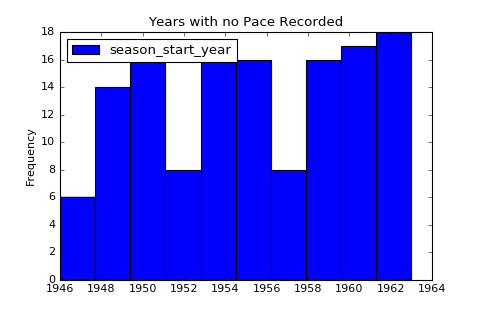

In [296]:
# Plot years that don't have pace recorded
ax = teamAggDfToAnalyzePaceAdjusted[np.isnan(teamAggDfToAnalyzePaceAdjusted['perGameStats_MP'])][['season_start_year']].plot(kind = 'hist', title = 'Years with no Pace Recorded')

# Years come up as scientific notation by default, turn off
ax.ticklabel_format(useOffset=False)

# Years ticks are separated by 0.5 by default (e.g. 2001, 2001.5, 2002, 2002.5)... some black magic to make labels whole numbers
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

Fortunately, our guess was correct. Looks like teams before 1964-ish doesn't have pace recorded on basketball-reference. We've got about... 150 teams here. We can live without these, so let's drop these rows.

In [297]:
# Drop rows without pace
teamAggDfToAnalyzePaceAdjusted.dropna(subset = ['perGameStats_MP'], inplace = True)
print 'There have been {} teams in NBA history after dropping those which don\'t have recorded minutes played'.format(teamAggDfToAnalyzePaceAdjusted.shape[0])

There have been 1318 teams in NBA history after dropping those which don't have recorded minutes played


C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Awesome, let's check the bottom 10 again.

In [298]:
# Extract top 10 teams
teamAggDfToAnalyzeTiers['top'] = teamAggDfToAnalyzePaceAdjusted.head(topN)

# Extract bottom 10 teams
teamAggDfToAnalyzeTiers['bottom'] = teamAggDfToAnalyzePaceAdjusted.tail(topN)

print teamAggDfToAnalyzeTiers['bottom']

      season_start_year perGameStats_Tm  baseStats_W  baseStats_WLPerc  \
1345               1976             NYN           22             0.268   
1346               2002             DEN           17             0.207   
1349               1968             CHI           33             0.402   
1351               1967             SDR           15             0.183   
1362               1966             DET           30             0.370   
1363               1964             BOS           62             0.775   
1370               1964             DET           31             0.388   
1374               1972             PHI            9             0.110   
1386               1965             DET           22             0.275   
1407               1964             SFW           17             0.213   

      perGameStats_MP  baseStats_Pace  baseStats_Rel_Pace  baseStats_ORtg  \
1345            240.6           103.7                -2.8            92.2   
1346            240.6          

Ooooooook, we're still missing a bunch of values. Looks like it's time to google here. A bunch of stats weren't recorded before a specific period. Brb, googling...

![](https://www.google.ca/logos/doodles/2014/world-cup-2014-17-6237353874030592-hp.gif)

Blah, couldn't find a basketball gif. WHATEVER.

Some milestones I found:
- NBA started recoridng blocks in 1973
- NBA introduced the 3 point shot in 1979

I can't really find anything about the missing rebounds, steals, and turnovers though... let's just take everything after 1979.

In [299]:
teamAggDfToAnalyzePaceAdjusted1979 = teamAggDfToAnalyzePaceAdjusted[teamAggDfToAnalyzePaceAdjusted['season_start_year'] >= 1979]
print 'There have been {} teams in NBA history starting from the 79-80 season'.format(teamAggDfToAnalyzePaceAdjusted1979.shape[0])

There have been 1044 teams in NBA history starting from the 79-80 season


Cool, we just eliminated a third of our sample. That can't be great, but in a world where I don't know anything about basketball, pretty much everything is fair game. But seriously, this is probably still an okay way to go because I'd imagine the game was so different back then (even in the 80's, 90's, and 2000's). I don't think many videos even exist in the Wilt era so it may be difficult to gauge those teams without highlights OR stats.

In [300]:
# We'll give each team a unique identifier based on the year and team because some teams repeat (CHI)
teamAggDfToAnalyzePaceAdjusted1979['unique_team_id'] = teamAggDfToAnalyzePaceAdjusted1979['season_start_year'].astype(str) + '-' + teamAggDfToAnalyzePaceAdjusted1979['perGameStats_Tm'].astype(str)

# Extract top 10 teams
teamAggDfToAnalyzeTiersTop = teamAggDfToAnalyzePaceAdjusted1979.head(topN)

# Extract bottom 10 teams
teamAggDfToAnalyzeTiersBottom = teamAggDfToAnalyzePaceAdjusted1979.tail(topN)

print teamAggDfToAnalyzeTiersBottom

      season_start_year perGameStats_Tm  baseStats_W  baseStats_WLPerc  \
1238               1982             HOU           14             0.171   
1248               2002             MIA           25             0.305   
1250               2003             CHI           23             0.280   
1252               2002             CLE           17             0.207   
1267               1997             GSW           19             0.232   
1275               2014             PHI           18             0.220   
1287               2011             CHA            7             0.106   
1302               1999             CHI           17             0.207   
1339               1998             CHI           13             0.260   
1346               2002             DEN           17             0.207   

      perGameStats_MP  baseStats_Pace  baseStats_Rel_Pace  baseStats_ORtg  \
1238            240.6           102.2                -0.9            97.0   
1248            241.8          

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Thank the lord. The things you go through just to do put together a few graphs... Not yet though.

## The Good
Let's take a look at some of the best teams alongside the "Blew a 3-1 Lead' warriors and Jordan's bulls.

In [301]:
pd.set_option('display.max_columns', len(teamAggDfToAnalyzeTiersTop.columns))
print(teamAggDfToAnalyzeTiersTop)
pd.reset_option('display.max_columns')

   season_start_year perGameStats_Tm  baseStats_W  baseStats_WLPerc  \
0               2016             GSW           64             0.821   
1               1986             LAL           65             0.793   
2               1991             CHI           67             0.817   
3               1987             BOS           57             0.695   
4               2009             PHO           54             0.659   
5               1995             CHI           72             0.878   
6               1994             ORL           57             0.695   
7               1986             DAL           55             0.671   
8               2016             HOU           52             0.675   
9               1994             SEA           57             0.695   

   perGameStats_MP  baseStats_Pace  baseStats_Rel_Pace  baseStats_ORtg  \
0            241.3            99.8                 3.4           115.7   
1            240.6           101.6                 0.8           115.6

Oops, my bad, the 3-1 warriors aren't even on this list. Instead the current warriors are... hmm ok. And not only that, they are **#1**. WHATEVER WORKS.

Let's look at a few metrics based on pace.

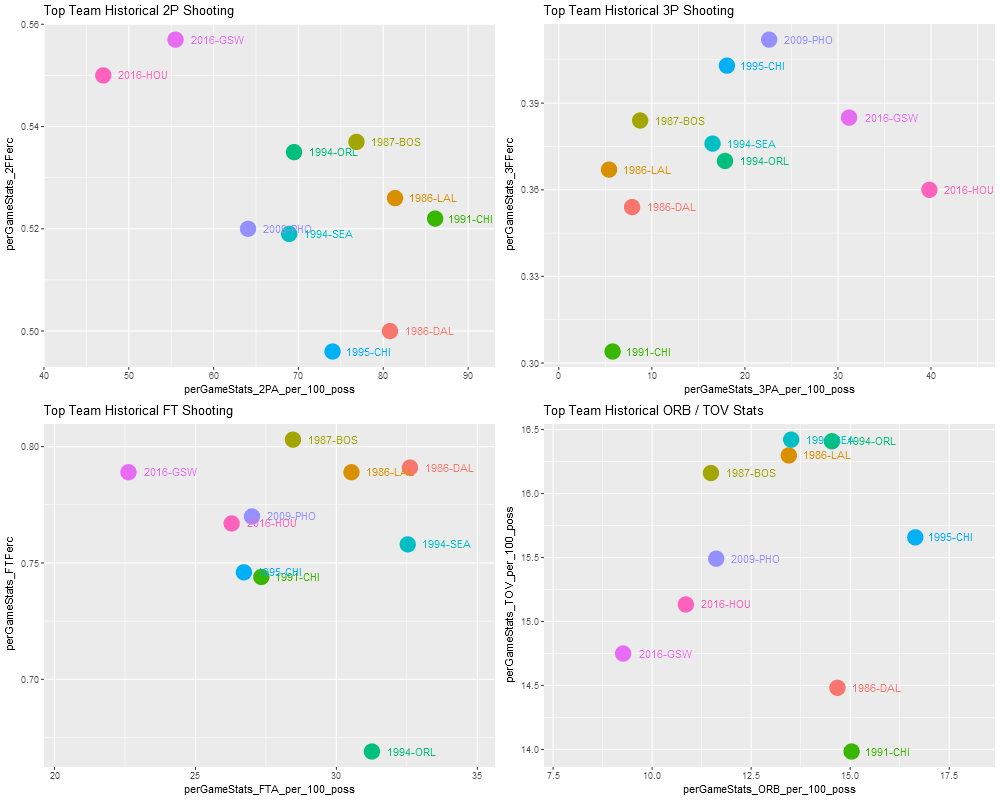

In [302]:
%%R -i teamAggDfToAnalyzeTiersTop -w 1000 -h 800 -u px

leagueNTeamsPlot <- function(tiersDf, tier){
    # 2PA Scatter
    leagueNTeams2PShooting = ggplot(
        tiersDf,
        aes(
            x = perGameStats_2PA_per_100_poss,
            y = perGameStats_2PPerc,
            color = unique_team_id,
            label = unique_team_id
        )
    ) + 
    geom_point(size = 7) +
    geom_text(hjust = -0.3) +
    ggtitle(sprintf("%s Team Historical 2P Shooting", tier)) +
    scale_x_continuous(expand = c(0, 7)) +
    theme(legend.position="none")
    
    # 3PA Scatter
    leagueNTeams3PShooting = ggplot(
        tiersDf,
        aes(
            x = perGameStats_3PA_per_100_poss,
            y = perGameStats_3PPerc,
            color = unique_team_id,
            label = unique_team_id
        )
    ) + 
    geom_point(size = 7) +
    geom_text(hjust = -0.3) +
    ggtitle(sprintf("%s Team Historical 3P Shooting", tier)) +
    scale_x_continuous(expand = c(0, 7)) + 
    theme(legend.position="none")
    
    # FTA Scatter
    leagueNTeamsFTShooting = ggplot(
        tiersDf,
        aes(
            x = perGameStats_FTA_per_100_poss,
            y = perGameStats_FTPerc,
            color = unique_team_id,
            label = unique_team_id
        )
    ) + 
    geom_point(size = 7) +
    geom_text(hjust = -0.3) +
    ggtitle(sprintf("%s Team Historical FT Shooting", tier)) +
    scale_x_continuous(expand = c(0, 3)) + 
    theme(legend.position="none")
    
    # ORB / TOV Scatter
    leagueNTeamsORBTOVShooting = ggplot(
        tiersDf,
        aes(
            x = perGameStats_ORB_per_100_poss,
            y = perGameStats_TOV_per_100_poss,
            color = unique_team_id,
            label = unique_team_id
        )
    ) + 
    geom_point(size = 7) +
    geom_text(hjust = -0.3) +
    ggtitle(sprintf("%s Team Historical ORB / TOV Stats", tier)) +
    scale_x_continuous(expand = c(0, 2)) + 
    theme(legend.position="none")


    grid.arrange(leagueNTeams2PShooting, leagueNTeams3PShooting, leagueNTeamsFTShooting, leagueNTeamsORBTOVShooting, ncol = 2)
}

leagueNTeamsPlot(teamAggDfToAnalyzeTiersTop, 'Top')

Observations in no particular order
- **Turnovers** aren't a huge factor among all these teams. Largest gap is 2.5 turnovers which, to me, is negligible
- **Offensive rebounds**, on the other hand, give 8-9 extra possessions to the best rebounding team vs the worst (today's GS warriors!)
- The **GSW, HOU, and PHO** teams are all quite close to one another in all of the charts... I think they can be summed up as high volume 3-point shooting teams who don't shoot too many free throws or grab too many boards, but they are all assasins when it comes to shooting from anywhere on the floor almost
    - In fact, the GSW and HOU teams are also among **the best 2P and FT shooting teams** on the list!
    - Basically, these guys can just shoot the lights out
- The **DAL and LAL** teams made a lot of good, high percentage shots from inside the 3, got to the line a ton, and grabbed a considerable amount of boards (which we can presume led to some high percentage shots / FT opportunities)
- The **95 bulls** looked like a hybrid, they hit a lot of 2's, they hit a considerable amount of 3's (at a greater percentage than today's HOU and GSW teams), and they grabbed a ton of boards

A few different styles here... I mean, these teams are the 10 best offensive teams of all time, nitpicking amongst some of these stats (other than some obvious ones like 94-ORL FT% or 91-CHI 3P%) seems irrelevant.

## The Ugly
Let's see what the worst teams look like

In [303]:
pd.set_option('display.max_columns', len(teamAggDfToAnalyzeTiersBottom.columns))
print(teamAggDfToAnalyzeTiersBottom)
pd.reset_option('display.max_columns')

      season_start_year perGameStats_Tm  baseStats_W  baseStats_WLPerc  \
1238               1982             HOU           14             0.171   
1248               2002             MIA           25             0.305   
1250               2003             CHI           23             0.280   
1252               2002             CLE           17             0.207   
1267               1997             GSW           19             0.232   
1275               2014             PHI           18             0.220   
1287               2011             CHA            7             0.106   
1302               1999             CHI           17             0.207   
1339               1998             CHI           13             0.260   
1346               2002             DEN           17             0.207   

      perGameStats_MP  baseStats_Pace  baseStats_Rel_Pace  baseStats_ORtg  \
1238            240.6           102.2                -0.9            97.0   
1248            241.8          

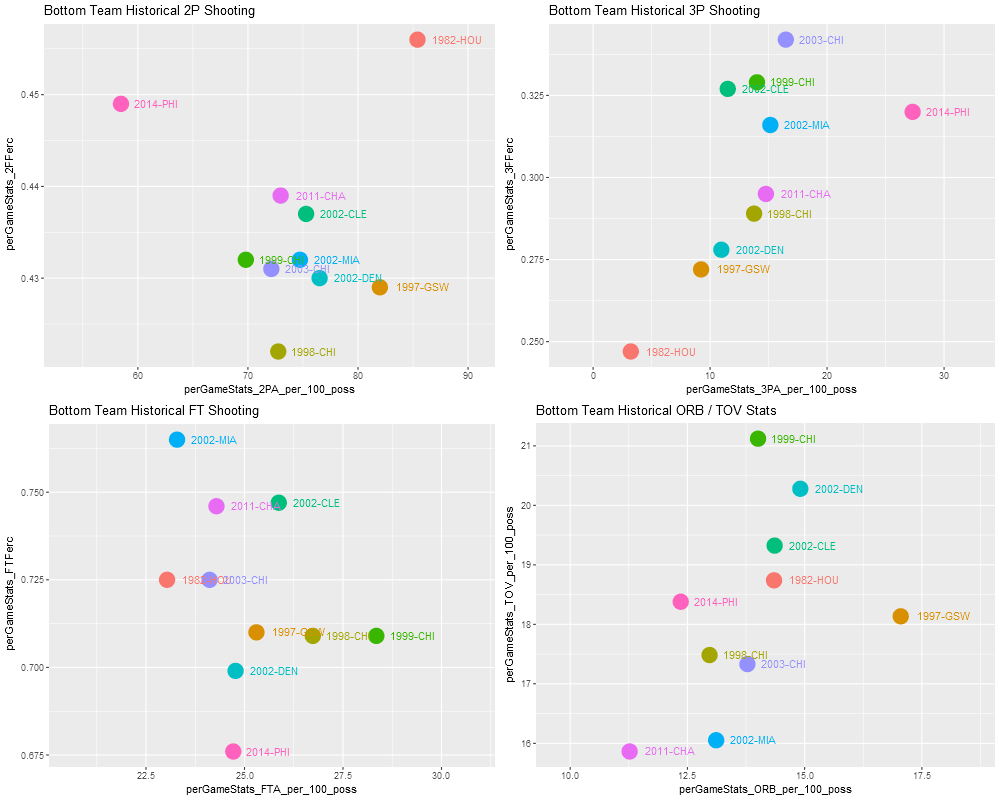

In [318]:
%%R -i teamAggDfToAnalyzeTiersBottom -w 1000 -h 800 -u px

leagueNTeamsPlot(teamAggDfToAnalyzeTiersBottom, 'Bottom')

Again, some observations:
- ORtg of these teams are about **20 points less / 100 possessions** than the best teams, that's ALOT of points going missing
- **Turnovers** are starting to come into play... The median of the good teams were about 15 turnovers, we're not getting into 18-19 turnovers where those 3-4 extra turnovers are costing maybe 5-6 points!
- These teams demonstrated fairly poor **shooting** from the floor at both 2P range and 3P range
    - From 2P range, we're seeing, in many cases, similar amounts of shots attempted, but they're hitting at **10%** less accuracy. If we take 75 shots / 100 possessions, 10% more shots going in means another ~8 shots going in, resulting in 16 points!
    - From 3P range, again, similar amount of attempts, but they're hitting at **~8%** less accuracy. Shooting 15 threes, that's about 1-2 threes less, good for up to 6 points!
    
On the turnover front, let's take a look at some of these teams' guards
- **2014-PHI** - Guards on opening night were... actually, I don't even know who the guards were on this team. Is that bad (on my part)? The starters were **Tony Wroten, Noel, Chris Johnson, Hollis Thompson, Henry Sims**. I think Tony Wroten is a guard, and I know Noel is not a guard, so I randomly guessed that Henry Sims was the second guard. Upon double-checking, I was incorrect and the answer was Hollis Thompson. I would've lost _**a lot**_ of money on "Who He Play For", or even just "Is He A Basketball Player". Honest to God and truth be told, I couldn't really tell you what makes a great point guard. There's a lot of intangibles that goes into a good point guard... leadership, court vision, ball handling. I couldn't tell you whether Chris Paul was a better point guard than Deron Williams back in the day, but I can tell you that Hollis Thompson probably isn't the guard you want starting.
- **1998-CHI** - Look at all the post-Jordan CHI teams on here in general, lol. That's crazy. Let's just look at one of them. The season right after Jordan's second three-peat. The point guards on the team were **Randy Brown, Charles Jones, and Rusty LaRue**. Not only did Jordan leave, but Pippen and Rodman also left. Enough said here.
- **2002-CLE** - I remember this team being around. This was when a few teams outright sucked. I remember thinking CLE, LAC, and GSW around this era was simply horrible. Not to mention the raps were post-VC and they were also pretty horrible haha. It's so weird to see these teams on top of the league now. Anyways, let's check out this CLE team's guards: **Milt Palacio, Tierre Brown, Smush Parker, Dajuan Wagner, Ricky Davis**. Actually, this doesn't sound quite as bad as the Philly team, but I definitely remember thinking "man Cleveland sucks!". They also had pretty outdated jerseys back then and that just made them seem like more of a joke. Yes, this is coming from me, the armchair GM.

On the shooting front, I don't want to make any generalizations because there's a lot that can go into this. Coaching, players, injuries, playing style... So many things can factor into this. I'll just leave it at "bad shooting" for now.

## The Three Pointer
Perhaps the biggest takeaway from all my analysis so far, and I think I've said it before, is just seeing how the game is changing and how shots are transitioning from 2's to 3's.

The Engineer inside of me wants to quantify this a little bit. We saw that old school teams were shooting around 75 2PA and 10 3PA for about 85 FGA / 100 possessions. At the most extreme, what we're seeing from today's rockets is 45 2PA and 40 3PA.

Below are your average shooting percentages:

<IPython.core.display.Javascript object>


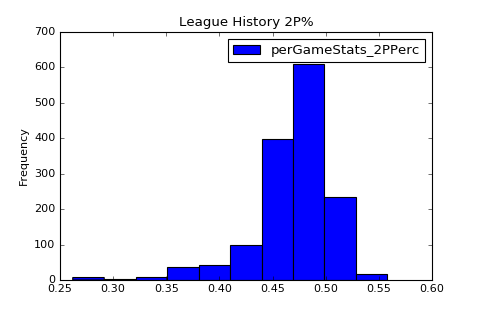

perGameStats_2PPerc    0.469417
dtype: float64


In [305]:
teamAggDfToAnalyze[['perGameStats_2PPerc']].plot(kind = 'hist', title = 'League History 2P%')
print teamAggDfToAnalyze[['perGameStats_2PPerc']].mean()

<IPython.core.display.Javascript object>


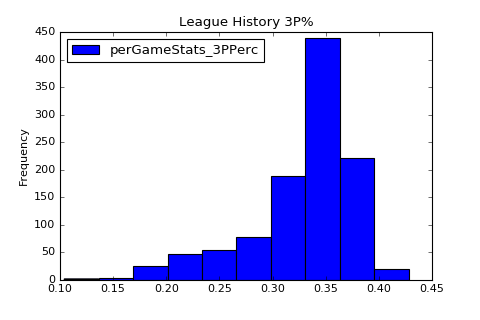

perGameStats_3PPerc    0.328943
dtype: float64


In [306]:
teamAggDfToAnalyze[['perGameStats_3PPerc']].plot(kind = 'hist', title = 'League History 3P%')
print teamAggDfToAnalyze[['perGameStats_3PPerc']].mean()

We're seeing about an average of 47% on 2PA and 33% on 3PA. I wonder what % at 3 you'd have to shoot to make up for all the missed 3's.

How many points does this generally come out to?
$$(75\ 2PA\times 47\%\times 2\ Points)+(10\ 3PA\times 33\%\times 3\ Points)=80.4\ Points$$


For example, Let's take the extreme case where all your 90 FGA are 3's and you shoot them at league average 33%:
$$85\ 3PA\times 33\%\times 3\ Points=84.2\ Points$$

Historically, I'm kinda paraphrasing here with some numbers off the top of my head, but even great shooters will shoot the 3 ball at around 40%. In the Miami days, Ray Allen was shooting the 3 around 40%. He has gone above 45% even, but he's the greatest 3 point shooter of all time. A role player like Shane Battier was known to jack up a corner 3 if he was open, and he shot it around 40% at his career as well. A player like Terrence Ross was known as a 3-and-D player and he never broke 40%. Even back in the Toronto hayday, someone like Jorge Garbajosa (I think) was regarded as a respectable 3-point shooter, and he would shoot the rock at 34% in his two years in Toronto. All this to say, great shooters shoot it around the average mark, and this is having plays essentially **designed so they get the optimal shot**, i.e. an open shot.

You can't really expect to waltz down and just hit a 3 every possession. People will be on you like a hawk and at some point you will be forced to take an easy two or turn it over. I'm saying this with a **DISCLAIMER THAT I AM OPEN TO BE PROVEN WRONG IN AS EARLY AS 5 YEARS TIME**.

<img src="http://assets.sbnation.com/assets/2563035/hardenwalkinghisdog.gif" style="width: 400px;"/>

---

Among the top 10 best offensive teams, we were seeing 2P% in the 50's, as high as 54-55%. The 87 celtics were basically shooting 54% / 39%, good for:
$$(75\ 2PA\times 54\%\times 2\ Points)+(15\ 3PA\times 39\%\times 3\ Points)=92.3\ Points$$

So if you were an average 3-point shooting team and all your points came from 3's, you'd still be 8 points off the 87 celtics. To match them, you would need to be shooting at
$$\frac{92.3\ Points}{85\ 3PA\times 3\ Points}=36\%$$

This means you pretty much need an elite 3 point shooter to take over the entire game or be coached so well that every single shot is a open and accurate look. Not likely.

### Technology Sidenote
Since I'm trying to plot a function of 2 variables with a response variable, a 3D plot is necessary. I've never tried the 3D plot functionality of matplotlib before, but I found a quick example here:

[http://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function](http://stackoverflow.com/questions/8722735/i-want-to-use-matplotlib-to-make-a-3d-plot-given-a-z-function)

I took my example from the second example given in the answer, utilizing the 'meshgrid', 'zip', 'reshape', and 'ravel' functions, and finally plotting using the Axes3D library. It's quite easy if we know the limits of X and Y, and the function of Z that we'd like to plot. In this case, I took X and Y as **3PA & 3P%**, and we can generalize our formulas above to:
$$(2PA\times 2P\%\times 2\ Points)+(3PA\times 3P\%\times 3\ Points)=Total\ Points$$

If we just look at what the surface plot would look like for an elite team with 
- Fixed 2P% (let's take 2P% as 50%)
- Fixed FGA (let's say 85 on average)
- 2PA as a function of 3PA = 2PA + 3PA = FGA

Then we get something like:
$$((85-3PA)\times 50\%\times 2\ Points)+(3PA\times 3P\%\times 3\ Points)=Total\ Points$$

<IPython.core.display.Javascript object>


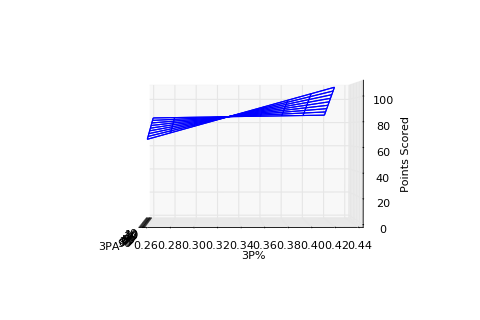

In [308]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Here we define the function that outputs how many points will be scored as a function of 3PA and 3P%
def fun(threePA, threePPerc):
  return ((85-threePA)*0.5*2)+(threePA*threePPerc*3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Define 'X' values
threePA = np.arange(5, 95, 10)
# Define 'Y' values
threePPerc = np.arange(0.26, 0.44, 0.02)

# Find a grid of overlapping X to Y values
X, Y = np.meshgrid(threePA, threePPerc)

# Calculate Z value for each X-Y pair
pointsScored = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = pointsScored.reshape(X.shape)

# Prepare & plot
ax.plot_wireframe(X, Y, Z)

ax.set_xlabel('3PA')
ax.set_ylabel('3P%')
ax.set_zlabel('Points Scored')

ax.set_zlim(0, 110)

plt.show()

We can see that if a team attemps 0 3PA, it's obviously that the 3P% won't matter. The team will end up with 85 points on FGA because they will only be shooting 2's, and they're shooting it at 50%

As soon as a team starts shooting any amount of 3's, it really depends on how well they shoot the 3 ball to understand how many points they'll score. A team will have to shoot the 3 ball at at least 33% to match the efficiency they are shooting the 2 ball at, and anything above that, they're actually more efficient the more 3PA they can manage.

Does this make sense? I think so. At 50%, 2PA's are essentially "worth" 1 point. 85 2PA @ 50% get you 85 points, 1 point / 2PA.

At 33%, each 3PA is "worth" 1 point. 85 3PA @ 33% also get you ~85 points (would be 33.33% repeating for an even 85). 1 point / 3PA! If you're shooting better than 33%, each shot you take is **worth** more than 1 point.

The average NBA team throughout history, again, shoots the 2 ball at ~47% and the 3 ball at ~33%. This is interesting - teams, on average, are actually shooting the 3-ball more efficiently! Not by a lot, but if we extrapolate this out to a whole season, it may make quite the difference. Again, I didn't watch too much basketball in the 80's and 90's, I can only imagine what types of plays were drawn up, but I don't think you had the culture or the shooters to do whatever James Harden was doing in that gif above. 3's were shot at 33% on average, but most of these were, again, designed plays to get a player wide open, and not quite sustainable across an entire game (e.g. to be able to shoot 50% of your FGA like HOU is doing now).

Let's contrast that Harden gif with this one:
![](http://giant.gfycat.com/BackFickleArchaeocete.gif)

Same result!

I just want to build that same 3D plot again, and instead of absolute points, I want to see how many times more / less points you would be scoring relative to if you only shot 2's (85 points)

<IPython.core.display.Javascript object>


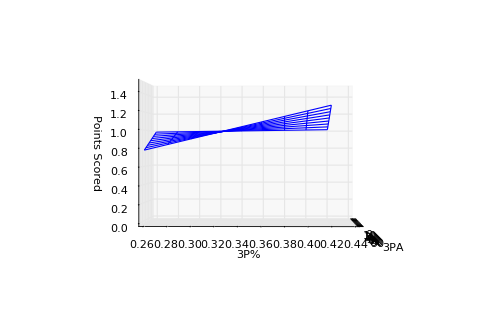

In [316]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Prepare & plot
ax.plot_wireframe(X, Y, Z/85)

ax.set_xlabel('3PA')
ax.set_ylabel('3P%')
ax.set_zlabel('Points Scored')

ax.set_zlim(0, 1.5)

plt.show()

This is pretty interesting, because they're getting about 10% more output by shooting the volume of 3's that they do at the % they shoot compared to a team that just shot 2's at a really good rate. You'll never see a team shoot only 2's these days, but teams definitely shoot at 2P% and 3P% for the same **efficiency** that that team would be shooting it at.

Again, a team shooting 50% 2P% is a really good 2P shooting team, on 85 shots, would be getting **85 points on 85 shots**.

The 2014 sixers shot 58 2PA @ 45%, 28 3PA @ 32%, and that's good for about **79 points on 86 shots**. A team shooting consistently at 50% 2PA without any 3PA would've won any game vs that 2014 sixers team (GROSSLY OVERSIMLPIFYING, I KNOW, BUT JUST TRYING TO COMMUNICATE A POINT).

Just for kicks, I want to see how much of an impact 3P shooting would have on a team that shoots subpar 2P. Let's say 43% 2P%, where a lot of those bad teams were bunched.

<IPython.core.display.Javascript object>


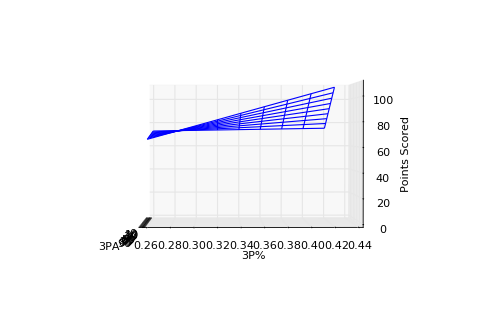

In [317]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Here we define the function that outputs how many points will be scored as a function of 3PA and 3P%
def fun(threePA, threePPerc):
  return ((85-threePA)*0.43*2)+(threePA*threePPerc*3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Define 'X' values
threePA = np.arange(5, 95, 10)
# Define 'Y' values
threePPerc = np.arange(0.26, 0.44, 0.02)

# Find a grid of overlapping X to Y values
X, Y = np.meshgrid(threePA, threePPerc)

# Calculate Z value for each X-Y pair
pointsScored = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = pointsScored.reshape(X.shape)

# Prepare & plot
ax.plot_wireframe(X, Y, Z)

ax.set_xlabel('3PA')
ax.set_ylabel('3P%')
ax.set_zlabel('Points Scored')

ax.set_zlim(0, 110)

plt.show()

By this graph, a team only has to shoot 28% on 3's to efficiently match the 43% on 2's, but this is setting the bar **low**.

## Tying It All Together
In terms of offence, after looking at all these stupid graphs and charts, it just comes down to putting the ball in the hole, I guess lol. Good teams will find more efficient ways to put the ball in the hole. Better looks, better shooters, better coaching, better plays. Taking care of the basketball and having the tenacity to grab ORB is definitely important as well, but turnovers can only account for so many lost points and ORBs will only matter if you can put the ball in the hole the second time, otherwise it makes you even **LESS** efficient!

Of course, I've been speaking about the game as if the only thing that matters if offence, and even then I'm just scratching the surface of offence, but I think it's worth getting a more complete picture by incorporating some defensive metrics as well, and taking a look at the best and worst defensive teams.